In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10

In [124]:
num_classes = 10
input_shape = (32,32,3)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train[0].shape)

#y_tain = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))

(32, 32, 3)


In [125]:
print(type(x_train[0][0][0][0]))
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

<class 'numpy.uint8'>
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [126]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [134]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape, name='input'),
        layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', name='conv11'),
        #layers.Conv2D(32, kernel_size=(3,3), activation='relu', name='conv12'),
        layers.MaxPooling2D(pool_size=(2,2), name='pool1'),
        layers.Dropout(.25),
        layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', name='conv21'),
        #layers.Conv2D(64, kernel_size=(3,3), activation='relu', name='conv22'),
        layers.MaxPooling2D(pool_size=(2,2), name='pool2'),
        layers.Dropout(.25),
        layers.Flatten(),
        layers.Dense(512, activation='relu', name='dense1'),
        layers.Dropout(.5),
        layers.Dense(num_classes, activation='softmax', name='output'),
    ]
)

In [135]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [138]:
batch_size = 32
epochs = 10
num_predictions = 20
save_dir = "cifar10/saved_models"
model_name = "keras__cifar10_trained_model_50e.h5"

In [139]:
model.fit(x_train, y_train, 
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
         shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 73s 1ms/sample - loss: 1.5175 - accuracy: 0.4500 - val_loss: 1.2158 - val_accuracy: 0.5728
Epoch 2/10
50000/50000 [==============================] - 63s 1ms/sample - loss: 1.1898 - accuracy: 0.5771 - val_loss: 1.0228 - val_accuracy: 0.6475
Epoch 3/10
50000/50000 [==============================] - 63s 1ms/sample - loss: 1.0721 - accuracy: 0.6210 - val_loss: 0.9632 - val_accuracy: 0.6645
Epoch 4/10
50000/50000 [==============================] - 64s 1ms/sample - loss: 0.9973 - accuracy: 0.6482 - val_loss: 0.8765 - val_accuracy: 0.7013
Epoch 5/10
50000/50000 [==============================] - 66s 1ms/sample - loss: 0.9476 - accuracy: 0.6656 - val_loss: 0.8739 - val_accuracy: 0.6951
Epoch 6/10
50000/50000 [==============================] - 64s 1ms/sample - loss: 0.8964 - accuracy: 0.6835 - val_loss: 0.8978 - val_accuracy: 0.6891
Epoch 7/10
50000/50000 [==============================] 

In [140]:
import os

In [141]:
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

In [142]:
scores = model.evaluate(x_test, y_test, verbose=1)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

10000/10000 [==============================] - 2s 245us/sample - loss: 0.7651 - accuracy: 0.7341
Test loss: 0.7650848474502564
Test accuracy: 0.7341


In [143]:
print(type(model.summary()))


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv11 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv21 (Conv2D)              (None, 16, 16, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4096)             

In [150]:
layer_name = "conv11"
layer = model.get_layer(name=layer_name)
#print(model.inputs)
#print(model.output)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

In [151]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    #print(input_image.shape)
    #print(filter_index)
    #print(activation.shape)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)


def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    grads = tape.gradient(loss, img)
    grads = tf.math.l2_normalize(grads)
    img += learning_rate*grads
    return loss, img


def initialize_image():
    img = tf.random.uniform((1, img_width, img_height, 3))
    return (img-0.5) * 0.25


def visualize_filter(filter_index):
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)
        
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15
    img = img [:,:,:]
    img += 0.5
    img = np.clip(img, 0, 1)
    img *= 255
    img = np.clip(img, 0, 255).astype('uint8')
    return img

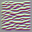

(32, 32, 3)


In [160]:
from IPython.display import Image, display
import tensorflow as tf


img_width = 32
img_height = 32
filter_No = 7 
loss, img = visualize_filter(filter_No)
img_name = layer_name+"-"+str(filter_No)+"cifar.png"
keras.preprocessing.image.save_img(img_name, img)

display(Image(img_name))
print(img.shape)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

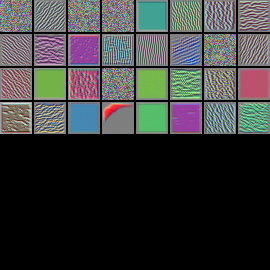

In [165]:
all_imgs = []
for filter_index in range(64):
    print("Processing filter %d" % (filter_index,))
    try:
        loss, img = visualize_filter(filter_index)
        #print(img.shape)
    except tf.errors.InvalidArgumentError as e:
        img = np.zeros((img_width, img_height, 3))
    all_imgs.append(img)

margin = 2
n = 8
#cropped_width = img_width - 25 * 2
#cropped_height = img_height - 25 * 2
cropped_width = img_width
cropped_height = img_height 
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
stiched_img_name = "stiched_filters-cifar-"+layer_name+"-"+str(epochs)+".png"
keras.preprocessing.image.save_img(stiched_img_name, stitched_filters)

display(Image(stiched_img_name))